# Import necessary packages

In [1]:

import os
import glob
import sys
import random

import matplotlib.pylab as plt
from PIL import Image, ImageDraw

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from torchvision import datasets, models, transforms
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

import numpy as np

from sklearn.model_selection import ShuffleSplit

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

%matplotlib inline

sys.path.insert(0, '..')
from src.models.utils import FaceDataset, initialize_backbone, get_list_backbones
from src.models import experiment
from src.models.experiment import Performance


In [2]:
import matplotlib.pyplot as plt
def show(img,label=None):
    npimg = img.numpy().transpose((1,2,0))
    plt.imshow(npimg)
    if label is not None:
        label = label.view(-1,2)
        for point in label:
            x,y= point
            plt.plot(x,y,'b+',markersize=10)

In [3]:
class Net(nn.Module):
    def __init__(self, params_model):
        super(Net, self).__init__()
        
        # Loading backbone architecture
        self.backbone = params_model["backbone"]  
        num_features = params_model["num_features"]  
        
        # Plug our heads
        self.gender_head = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(num_features, 1)
        )
        
        self.age_head = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(num_features, 1)
        )
        
        return None

    def forward(self, x):
        f = self.backbone(x)
        f = f.view(f.size(0), -1)
        gender = torch.sigmoid(self.gender_head(f))
        age = self.age_head(f)
        return age, gender

In [4]:
def get_transformer(target_size):
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(target_size,interpolation=Image.NEAREST),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize(target_size,interpolation=Image.NEAREST),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }
    
    def train_transformer(image, label, params=None):
        image = data_transforms["train"](image)
        return image, label
    
    def val_transformer(image, label, params=None):
        image = data_transforms["val"](image)
        return image, label
        
    return train_transformer, val_transformer


def get_data_loader(params_dl):
    input_size = params_dl["input_size"]
    path2data = params_dl["path2data"]
    train_batch_size = params_dl["train_batch_size"]
    val_batch_size = params_dl["val_batch_size"]
    
    # create data transformer
    target_size = (input_size, input_size)    
    train_transformer, val_transformer = get_transformer(target_size)

    # create data set
    train_ds = FaceDataset(path2data + "train.csv", train_transformer)
    val_ds = FaceDataset(path2data + "valid.csv", val_transformer)
    test_ds = FaceDataset(path2data + "test.csv", val_transformer)
    
    train_dl = DataLoader(train_ds, batch_size = train_batch_size, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size = val_batch_size, shuffle=False)
    test_dl = DataLoader(test_ds, batch_size = val_batch_size, shuffle=False)
    
    return train_dl, val_dl, test_dl



In [5]:
class CustomPerformance(Performance):
    def __init__(self):
        Performance.__init__(self)
        self.gender_loss_func = nn.BCELoss(reduction="sum")
        self.age_loss_func = nn.MSELoss(reduction="sum")
        
    def loss_function(self, predictions, targets):
        age, gender = predictions
        gender_targets = targets[:, 1].unsqueeze(1)
        age_targets = targets[:, 0].unsqueeze(1)
        
        loss_age = self.age_loss_func(age, age_targets)
        
        loss_gender = self.gender_loss_func(gender, gender_targets)
        
        loss = loss_age + 50*loss_gender
        
        return loss

    def metrics_function(self, predictions, targets):
        age, gender = predictions
        gender_targets = targets[:, 1].unsqueeze(1)
        age_targets = targets[:, 0].unsqueeze(1)
        
        gender = gender > 0.5
        acc_gender = (gender == gender_targets).sum()
        
        mae_age = torch.abs(age - age_targets).sum()
        
        return torch.tensor([acc_gender, mae_age])

# Resnet18 Investigation

In [6]:
get_list_backbones()


['Mobilenet_v2',
 'Restnet18',
 'Alexnet',
 'VGG11_bn',
 'Squeezenet1_0',
 'Densenet121']

In [7]:
# get backbone 
backbone, input_size, num_features = initialize_backbone(backbone_name="Resnet18", feature_extract=False, 
                                             use_pretrained=True)
params_model={
        "backbone": backbone,
        "num_features": num_features,  
            }

# create model
model = Net(params_model)
device = torch.device("cuda")
model = nn.DataParallel(model)
model = model.to(device)

# create dataloaders
path2data = "/home/Data/appa-real/processed/"
params_dl = {
    "input_size" : input_size,
    "path2data" : path2data,
    "train_batch_size" : 128,
    "val_batch_size" : 256
}
train_dl, val_dl, test_dl = get_data_loader(params_dl)

In [8]:
for img_b, label_b in train_dl:
    print(img_b.shape,img_b.dtype)
    print(label_b.shape)
    break
    
for img_b, label_b in val_dl:
    print(img_b.shape,img_b.dtype)
    print(label_b.shape)
    break

for img_b, label_b in test_dl:
    print(img_b.shape,img_b.dtype)
    print(label_b.shape)
    break

torch.Size([128, 3, 224, 224]) torch.float32
torch.Size([128, 2])
torch.Size([256, 3, 224, 224]) torch.float32
torch.Size([256, 2])
torch.Size([256, 3, 224, 224]) torch.float32
torch.Size([256, 2])


In [9]:
opt = optim.Adam(model.parameters(), lr=1e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=10,verbose=1)

performance = CustomPerformance()
num_epochs = 30
path2models= "../models/weights.pt"
params = experiment.Prams(num_epochs=num_epochs, path2weights=path2models, device=device,optimizer=opt, lr_scheduler=lr_scheduler, sanity_check=False)

pipeline = experiment.Pipeline(model, train_dl, val_dl, performance, params)
model, performance = pipeline.train_val()

Epoch 0/29, current lr=0.0001
Copied best model weights!
train loss: 1085.843262
val loss: 1151.917847
Training epoch complete in 0m 27s
----------
Epoch 1/29, current lr=0.0001
Copied best model weights!
train loss: 854.416565
val loss: 664.174438
Training epoch complete in 0m 22s
----------
Epoch 2/29, current lr=0.0001
train loss: 699.456116
val loss: 794.654480
Training epoch complete in 0m 22s
----------
Epoch 3/29, current lr=0.0001
Copied best model weights!
train loss: 599.080933
val loss: 641.710938
Training epoch complete in 0m 22s
----------
Epoch 4/29, current lr=0.0001
Copied best model weights!
train loss: 515.432068
val loss: 529.885559
Training epoch complete in 0m 22s
----------
Epoch 5/29, current lr=0.0001
Copied best model weights!
train loss: 448.518768
val loss: 478.336945
Training epoch complete in 0m 22s
----------
Epoch 6/29, current lr=0.0001
Copied best model weights!
train loss: 386.053131
val loss: 371.327667
Training epoch complete in 0m 22s
----------
Epo

In [10]:
loss_hist, metrics_history = performance.loss_history, performance.metrics_history
train_hist = torch.stack(metrics_history["train"])
val_hist = torch.stack(metrics_history["val"])

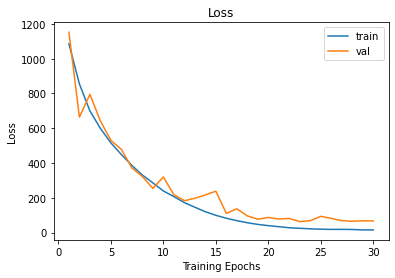

In [11]:
# Train-Validation Progress

# plot loss progress
plt.title("Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

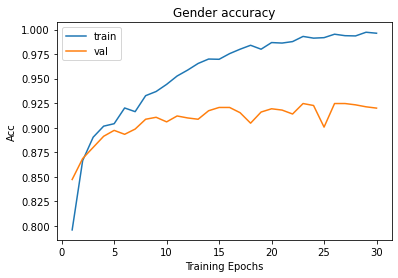

In [12]:
# plot accuracy progress
plt.title("Gender accuracy")
plt.plot(range(1,num_epochs+1),train_hist[:,0], label="train")
plt.plot(range(1,num_epochs+1),val_hist[:,0],label="val")
plt.ylabel("Acc")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

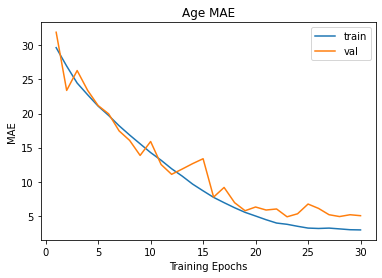

In [13]:
# plot accuracy progress
plt.title("Age MAE")
plt.plot(range(1,num_epochs+1),train_hist[:,1], label="train")
plt.plot(range(1,num_epochs+1),val_hist[:,1],label="val")
plt.ylabel("MAE")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [14]:
loss_test, metrics_test = pipeline.test(test_dl)

In [15]:
# Gender Accuracy
print(max(train_hist[:,0]))
print(max(val_hist[:,0]))
print(metrics_test[0])

tensor(0.9972)
tensor(0.9247)
tensor(0.9095)


In [16]:
# Age MAE
print(min(train_hist[:,1]))
print(min(val_hist[:,1]))
print(metrics_test[1])

tensor(2.9508)
tensor(4.8732)
tensor(5.9504)


In [17]:
# Loss
print(min(loss_hist["train"]))
print(min(loss_hist["val"]))
print(loss_test)

tensor(15.1803, device='cuda:0', grad_fn=<DivBackward0>)
tensor(62.9308, device='cuda:0')
tensor(81.8075, device='cuda:0')
